# Classification d'images de fientes (healthy, cocci, salmo, ncd)

### 1. Chargement et préparation du dataset

In [5]:
# 1. Importation des packages et initialisation
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
from collections import Counter

print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print("GPU détectée :" if gpus else "Aucun GPU détecté", gpus)
# Fixer les seeds pour la reproductibilité
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


TensorFlow version: 2.20.0
Aucun GPU détecté []


### 1) Inspection des données & distribution initiale

In [ ]:
# data_dir = 'data/images'
# classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
# print("Classes détectées :", classes)

# paths = []
# labels = []
# for cls in classes:
#     cls_dir = os.path.join(data_dir, cls)
#     for fname in os.listdir(cls_dir):
#         if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
#             paths.append(os.path.join(cls_dir, fname))
#             labels.append(cls)

# # Puis on ajoute les images augmentées
# # Assurez-vous que 'ncd_aug' a le label 'ncd'
# aug_dir = os.path.join(data_dir, 'ncd_aug')
# if os.path.exists(aug_dir):
#     for fname in os.listdir(aug_dir):
#         if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
#             paths.append(os.path.join(aug_dir, fname))
#             labels.append('ncd')
            
# paths = np.array(paths)
# labels = np.array(labels)

# # Mélanger l'ordre des données
# indices = np.arange(len(paths))
# np.random.shuffle(indices)
# paths = paths[indices]
# labels = labels[indices]

# # Comptage des images par classe
# from collections import Counter
# dist = 
# 
# 
# 
# 
# 
# (labels)
# print("Distribution initiale des classes :", dist)

# plt.figure(figsize=(6,4))
# plt.bar(dist.keys(), dist.values(), color='skyblue')
# plt.title("Distribution initiale des classes")
# plt.ylabel("Nombre d'images")
# plt.xlabel("Classe")
# plt.show()


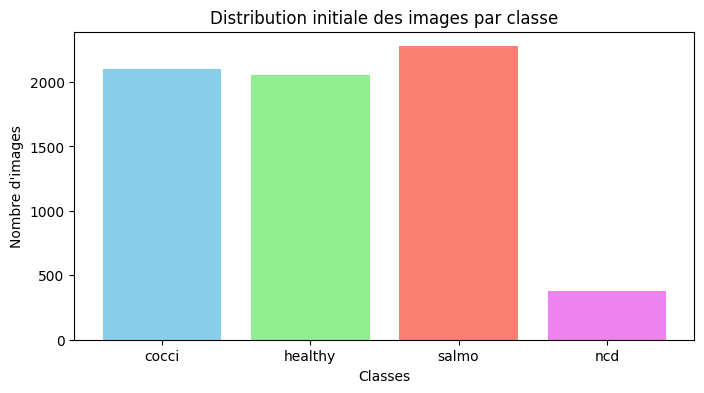

In [6]:
labels = ['cocci', 'healthy', 'salmo', 'ncd']
counts = [2103, 2057, 2276, 376]

plt.figure(figsize=(8,4))
plt.bar(labels, counts, color=['skyblue','lightgreen','salmon','violet'])
plt.title("Distribution initiale des images par classe")
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.show()

On observe que ncd newcastal est sous-représentée seulement 376 images sur 6812 total sa peut causer des probleme dapprentissage

Classes détectées : ['cocci', 'healthy', 'ncd', 'salmo']
Distribution initiale des classes (avec images augmentées) : Counter({np.str_('salmo'): 2276, np.str_('cocci'): 2103, np.str_('ncd'): 2085, np.str_('healthy'): 2057})


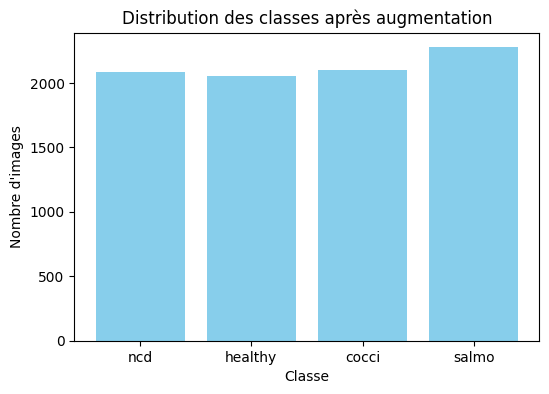

In [6]:
data_dir = 'data/images'

# On ignore le dossier 'ncd_aug' pour le moment
classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != 'ncd_aug'])
print("Classes détectées :", classes)

paths = []
labels = []

# 1. Parcourir les classes originales
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            paths.append(os.path.join(cls_dir, fname))
            labels.append(cls)

# 2. Ajouter les images augmentées de 'ncd_aug' à la classe 'ncd'
aug_dir = os.path.join(data_dir, 'ncd_aug')
if os.path.exists(aug_dir):
    for fname in os.listdir(aug_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            paths.append(os.path.join(aug_dir, fname))
            labels.append('ncd') # On attribue le label 'ncd' à ces images

paths = np.array(paths)
labels = np.array(labels)

indices = np.arange(len(paths))
np.random.shuffle(indices)
paths = paths[indices]
labels = labels[indices]

dist = Counter(labels)
print("Distribution initiale des classes (avec images augmentées) :", dist)

plt.figure(figsize=(6,4))
plt.bar(dist.keys(), dist.values(), color='skyblue')
plt.title("Distribution des classes après augmentation")
plt.ylabel("Nombre d'images")
plt.xlabel("Classe")
plt.show()


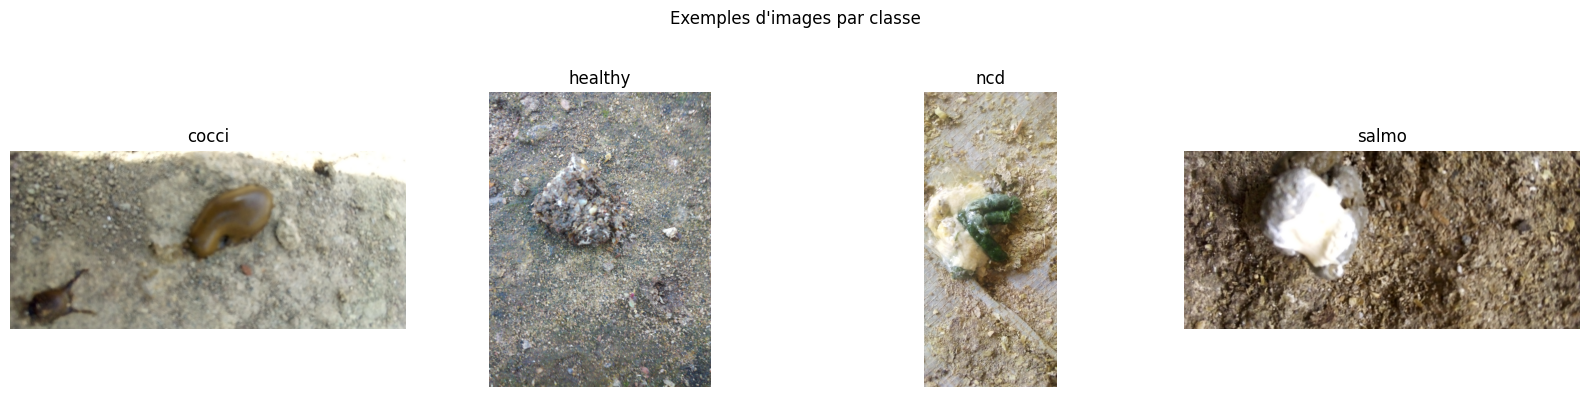

In [16]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

classes = ['cocci', 'healthy', 'ncd', 'salmo']
exemples_chemins = {
    'cocci': 'data/images/cocci/cocci.1000.jpg',
    'healthy': 'data/images/healthy/healthy.1004.jpg',
    'ncd': 'data/images/ncd/ncd.128.jpg',
    'salmo': 'data/images/salmo/salmo.0.jpg'
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Exemples d'images par classe")

for i, cls in enumerate(classes):
    try:
        img = mpimg.imread(exemples_chemins[cls])
        axes[i].imshow(img)
        axes[i].set_title(cls)
        axes[i].axis('off')
    except FileNotFoundError:
        axes[i].set_title(f"Image {cls} non trouvée")
        axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2) Split stratifié 70/15/15

Taille Train/Val/Test : 5964/1278/1279
Train - distribution : Counter({np.str_('salmo'): 1593, np.str_('cocci'): 1472, np.str_('ncd'): 1459, np.str_('healthy'): 1440})
Validation - distribution : Counter({np.str_('salmo'): 341, np.str_('cocci'): 315, np.str_('ncd'): 313, np.str_('healthy'): 309})
Test - distribution : Counter({np.str_('salmo'): 342, np.str_('cocci'): 316, np.str_('ncd'): 313, np.str_('healthy'): 308})


C:\Users\Macky\AppData\Local\Temp\ipykernel_5156\1586439602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(cnt.keys()), rotation=45)
C:\Users\Macky\AppData\Local\Temp\ipykernel_5156\1586439602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(cnt.keys()), rotation=45)
C:\Users\Macky\AppData\Local\Temp\ipykernel_5156\1586439602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(list(cnt.keys()), rotation=45)


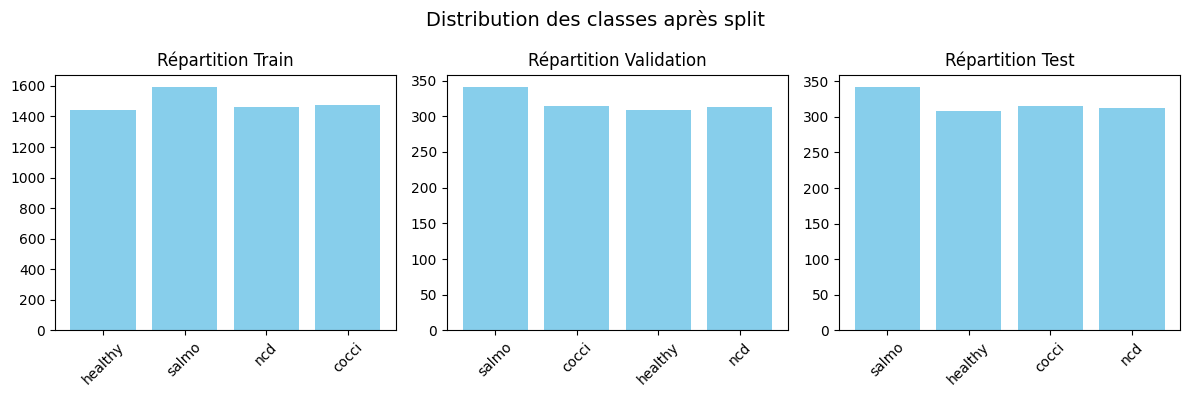

In [7]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    paths, labels, stratify=labels, test_size=0.3, random_state=seed)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, stratify=temp_labels, test_size=0.5, random_state=seed)

print(f"Taille Train/Val/Test : {len(train_paths)}/{len(val_paths)}/{len(test_paths)}")
for name, lbls in zip(["Train","Validation","Test"], [train_labels, val_labels, test_labels]):
    cnt = Counter(lbls)
    print(f"{name} - distribution : {cnt}")

# Barplots de répartition pour chaque ensemble
fig, axes = plt.subplots(1, 3, figsize=(12,4))
for ax, (subset_paths, subset_labels, title) in zip(
        axes,
        [(train_paths, train_labels, "Train"), (val_paths, val_labels, "Validation"), (test_paths, test_labels, "Test")]):
    cnt = Counter(subset_labels)
    ax.bar(cnt.keys(), cnt.values(), color='skyblue')
    ax.set_title(f"Répartition {title}")
    ax.set_xticklabels(list(cnt.keys()), rotation=45)
fig.suptitle("Distribution des classes après split", fontsize=14)
plt.tight_layout()
plt.show()


le split stratifier garantit que chaque ensemble a la meme distribution de classe que l'ensemble original

### 3) Encodage des labels et calcul des class weights

on crée deux dictionnaires class_to_index et index_to_class, puis on remplace le label texte par un entier dans les DataFrames. On calcule ensuite les poids de classes à l’aide de compute_class_weight, qui inversement pondère chaque classe selon sa fréquence.

In [8]:
class_names = sorted(list(set(train_labels)))
class_to_index = {cls:i for i, cls in enumerate(class_names)}
index_to_class = {i:cls for cls,i in class_to_index.items()}
print("Mapping classe→index :", class_to_index)

ncd_idx = class_to_index['ncd']

# Conversion des labels en indices
train_labels_idx = np.array([class_to_index[x] for x in train_labels])
val_labels_idx   = np.array([class_to_index[x] for x in val_labels])
test_labels_idx  = np.array([class_to_index[x] for x in test_labels])

# Calcul des poids de classe pour l'entraînement
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_idx),
    y=train_labels_idx)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Poids de classe calculés :", class_weights)


Mapping classe→index : {np.str_('cocci'): 0, np.str_('healthy'): 1, np.str_('ncd'): 2, np.str_('salmo'): 3}
Poids de classe calculés : {0: np.float64(1.012907608695652), 1: np.float64(1.0354166666666667), 2: np.float64(1.021932830705963), 3: np.float64(0.935969868173258)}


ici on utilisez un dictionnaire (class_to_index) pour transformer ['cocci', 'healthy', 'ncd', 'salmo'] en [0, 1, 2, 3]

Les poids de classe sont tous proches de 1, car la distribution est maintenant assez équilibrée

### 4) Prétraitement des images et pipeline tf.data

In [9]:
def load_and_preprocess(path, label):
    # Charge, décode, redimensionne et normalise l'image.
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    # Normalisation [-1,1] pour MobileNetV2
    img = tf.cast(img, tf.float32) / 127.5 - 1
    return img, label

# Création des datasets tf.data
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_idx))
train_ds = train_ds.shuffle(buffer_size=len(train_paths), seed=seed)
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_idx))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_idx))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Pipeline tf.data configuré avec un jeu de données d'entraînement pré-augmenté.")

Pipeline tf.data configuré avec un jeu de données d'entraînement pré-augmenté.


pour la classe ncd, on applique des transformations aléatoires (flip horizontal, rotation par 90°, rognage aléatoire) lors de l’appel à map. Ceci est fait via tf.cond pour n’appliquer l’augmentation que si label == 'ncd'

In [21]:
# # Identification de l'indice de la classe 'ncd'
# ncd_idx = class_to_index['ncd']

# # Suréchantillonnage (oversampling) pour équilibrer le jeu d'entraînement
# cnts = Counter(train_labels_idx)
# max_count = max(cnts.values())
# train_paths_list = train_paths.tolist()
# train_labels_list = train_labels_idx.tolist()
# for cls, cnt in cnts.items():
#     if cnt < max_count:
#         # nombre d'images à dupliquer pour la classe minoritaire
#         diff = max_count - cnt
#         cls_indices = [i for i, lab in enumerate(train_labels_list) if lab == cls]
#         sampled_indices = np.random.choice(cls_indices, size=diff, replace=True)
#         for i in sampled_indices:
#             train_paths_list.append(train_paths_list[i])
#             train_labels_list.append(train_labels_list[i])
# # Conversion en tableaux
# train_paths_bal = np.array(train_paths_list)
# train_labels_bal = np.array(train_labels_list)
# print("Distribution après suréchantillonnage :", Counter(train_labels_bal))

# # Définition des fonctions de prétraitement
# def load_and_preprocess(path, label):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [224, 224])
#     # Normalisation [-1,1]
#     img = tf.cast(img, tf.float32) / 127.5 - 1
#     return img, label

# def augment(image, label):
#     # Augmentation conditionnelle pour la classe 'ncd'
#     def do_aug():
#         aug_img = tf.image.random_flip_left_right(image)
#         k = tf.random.uniform([], 1, 4, dtype=tf.int32)
#         aug_img = tf.image.rot90(aug_img, k=k)
#         # rognage aléatoire puis resize
#         scale = tf.random.uniform([], 0.7, 1.0)
#         crop_size = tf.cast(scale * 224, tf.int32)
#         crop = tf.image.random_crop(aug_img, size=[crop_size, crop_size, 3])
#         aug_img = tf.image.resize(crop, [224, 224])
#         return aug_img
#     image = tf.cond(tf.equal(label, ncd_idx), do_aug, lambda: image)
#     return image, label

# def process_path(path, label):
#     image, label = load_and_preprocess(path, label)
#     image, label = augment(image, label)
#     return image, label

# # Création des datasets tf.data
# BATCH_SIZE = 32
# train_ds = tf.data.Dataset.from_tensor_slices((train_paths_bal, train_labels_bal))
# train_ds = train_ds.shuffle(buffer_size=len(train_paths_bal), seed=seed)
# train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_idx))
# val_ds = val_ds.map(lambda x,y: load_and_preprocess(x,y), num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels_idx))
# test_ds = test_ds.map(lambda x,y: load_and_preprocess(x,y), num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# print("Pipeline tf.data configuré avec oversampling et augmentation ciblée pour 'ncd'")


### 5) Modèle Baseline (CNN simple)

On définit un petit CNN “from scratch” comme point de départ : quelques couches Conv2D + max-pooling, suivi d’un Flatten et de couches denses. Le modèle est compilé avec SparseCategoricalCrossentropy (étiquettes entières) et on lui passe les class_weights. On entraîne sur notre jeu de train avec validation, en utilisant un callback d’EarlyStopping. On affiche ensuite les courbes d’entraînement (perte et précision) pour vérifier le comportement du modèle.

In [10]:
# 6. Modèle CNN baseline
def create_baseline_model(input_shape=(224,224,3), num_classes=len(class_names)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

model_baseline = create_baseline_model()
model_baseline.compile(optimizer='adam', 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
model_baseline.summary()

print("Entraînement du modèle CNN de base...")
callbacks_baseline = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
history_baseline = model_baseline.fit(
    train_ds, validation_data=val_ds,
    epochs=20, class_weight=class_weights,
    callbacks=callbacks_baseline)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Entraînement du modèle CNN de base...
Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 139s 732ms/step - accuracy: 0.7689 - loss: 0.6656 - val_accuracy: 0.8936 - val_loss: 0.3198
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 144s 767ms/step - accuracy: 0.9014 - loss: 0.3142 - val_accuracy: 0.9131 - val_loss: 0.2358
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 148s 792ms/step - accuracy: 0.9240 - loss: 0.2217 - val_accuracy: 0.9171 - val_loss: 0.2214
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 150s 798ms/step - accuracy: 0.9351 - loss: 0.2037 - val_accuracy: 0.9374 - val_loss: 0.1741
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 149s 794ms/step - accuracy: 0.9515 - loss: 0.1547 - val_accuracy: 0.9452 - val_loss: 0.1753
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 156s 831ms/step - accuracy: 0.9594 - loss: 0.1179 - val_accuracy: 0.9335 - val_loss: 0.1895
Epoch 7/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 158s 840ms/step - accuracy: 0.9685 - loss: 0.0971 - val_accuracy: 0.9304 - val_loss: 0.2045
Epoch 8/20
187/187 ━━━━━━━━━━━━━━━━━━━

Le modèle CNN simple atteint ~95 % de précision de validation après 12 époques, ce qui est déjà excellent.

In [11]:
# # Évaluation complète du CNN Baseline
print("=== ÉVALUATION CNN BASELINE ===")
test_loss_baseline, test_acc_baseline = model_baseline.evaluate(test_ds)
y_pred_baseline = model_baseline.predict(test_ds)
y_pred_classes_baseline = np.argmax(y_pred_baseline, axis=1)

print("\nClassification Report Baseline:")
print(classification_report(test_labels_idx, y_pred_classes_baseline, 
                          target_names=class_names))

=== ÉVALUATION CNN BASELINE ===
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - accuracy: 0.9414 - loss: 0.2016
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 280ms/step

Classification Report Baseline:
              precision    recall  f1-score   support

       cocci       0.95      0.99      0.97       316
     healthy       0.93      0.94      0.94       308
         ncd       0.93      0.93      0.93       313
       salmo       0.96      0.92      0.94       342

    accuracy                           0.94      1279
   macro avg       0.94      0.94      0.94      1279
weighted avg       0.94      0.94      0.94      1279



les courbes d’apprentissage (loss et accuracy).

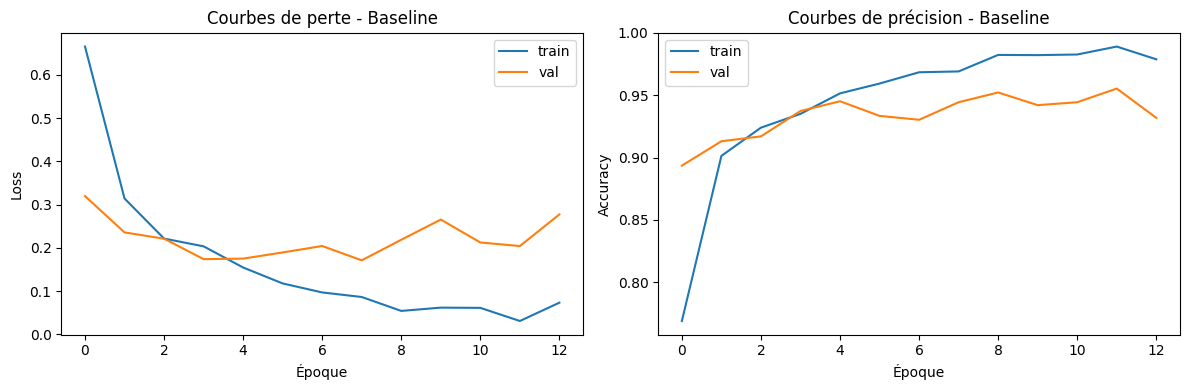

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_baseline.history['loss'], label='train')
plt.plot(history_baseline.history['val_loss'], label='val')
plt.title("Courbes de perte - Baseline")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_baseline.history['accuracy'], label='train')
plt.plot(history_baseline.history['val_accuracy'], label='val')
plt.title("Courbes de précision - Baseline")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


### 6) Transfer Learning : MobileNetV2

#### Phase 1 : MobileNetV2 gelé

Objectif : Utiliser MobileNetV2 pré-entraîné (sans top) comme extracteur de caractéristiques fixe. On ajoute un scalage (Rescaling), un GlobalAveragePooling, dropout, puis un classifieur Dense final. On entraîne seulement les couches ajoutées.

In [13]:
# 7. Modèle MobileNetV2 (transfer learning)
print("Phase 1 : MobileNetV2 gelé (features pré-entraînées)")
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                                              include_top=False, weights='imagenet')
base_model.trainable = False
inputs = layers.Input(shape=(224,224,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model_mobile = models.Model(inputs, outputs)
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
model_mobile.summary()

history_mobile = model_mobile.fit(
    # train_ds, validation_data=val_ds,
    train_ds, validation_data=val_ds,
    epochs=10, class_weight=class_weights,
    callbacks=callbacks_baseline)

print("Phase 2 : Fine-tuning partiel de MobileNetV2 (sans dégeler les BatchNorm)")
base_model.trainable = True
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
history_ft = model_mobile.fit(
    # train_ds, validation_data=val_ds,
    train_ds, validation_data=val_ds,
    epochs=10, class_weight=class_weights,
    callbacks=callbacks_baseline)


Phase 1 : MobileNetV2 gelé (features pré-entraînées)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 96s 494ms/step - accuracy: 0.8364 - loss: 0.4429 - val_accuracy: 0.9507 - val_loss: 0.1627
Epoch 2/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 96s 513ms/step - accuracy: 0.9321 - loss: 0.1963 - val_accuracy: 0.9577 - val_loss: 0.1268
Epoch 3/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 100s 531ms/step - accuracy: 0.9435 - loss: 0.1599 - val_accuracy: 0.9617 - val_loss: 0.1125
Epoch 4/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 105s 558ms/step - accuracy: 0.9492 - loss: 0.1397 - val_accuracy: 0.9664 - val_loss: 0.1020
Epoch 5/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 103s 548ms/step - accuracy: 0.9536 - loss: 0.1296 - val_accuracy: 0.9710 - val_loss: 0.0957
Epoch 6/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 99s 529ms/step - accuracy: 0.9542 - loss: 0.1284 - val_accuracy: 0.9624 - val_loss: 0.1035
Epoch 7/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 503ms/step - accuracy: 0.9621 - loss: 0.1107 - val_accuracy: 0.9664 - val_loss: 0.0965
Epoch 8/10
187/187 ━━━━━━━━━━━━━━━━━━━━ 94s 503ms/step - accuracy: 0.9611 - loss

Phase 1 : Le modèle se comporte très bien, atteignant une précision de validation de 97 %.

Phase 2 : Les résultats sont encore meilleurs, atteignant près de 99 % sur l'entraînement et 97 % sur la validation.

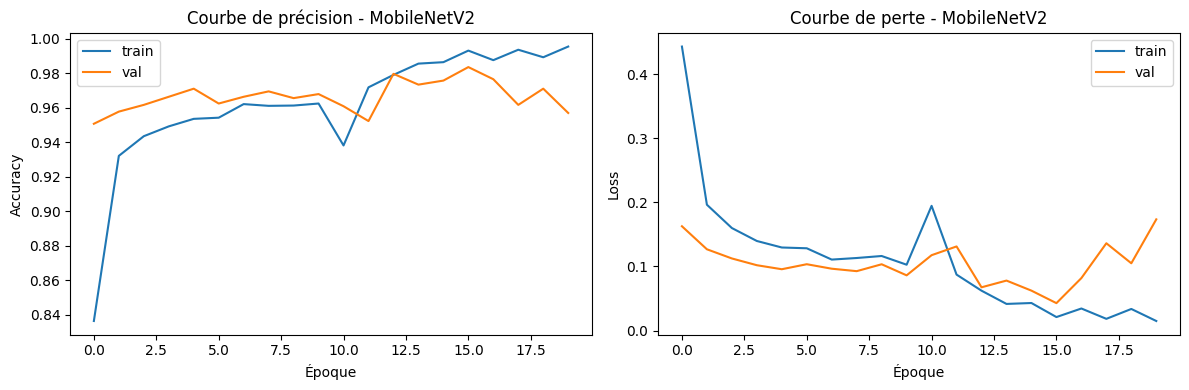

In [14]:
# Affichage des courbes pour MobileNetV2 (gelé + fine-tuning)
acc = history_mobile.history['accuracy'] + history_ft.history['accuracy']
val_acc = history_mobile.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history_mobile.history['loss'] + history_ft.history['loss']
val_loss = history_mobile.history['val_loss'] + history_ft.history['val_loss']

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.title("Courbe de précision - MobileNetV2")
plt.xlabel("Époque")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(loss, label='train')
plt.plot(val_loss, label='val')
plt.title("Courbe de perte - MobileNetV2")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


### 8. Évaluation finale sur le jeu de test

On évalue le modèle MobileNetV2 finetuné sur le jeu de test. On calcule précision (accuracy), précision, rappel, score F1 pour chaque classe, ainsi qu’une matrice de confusion.

Évaluation du modèle final sur le jeu de test...
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step - accuracy: 0.9805 - loss: 0.0593
Test Loss = 0.059, Test Accuracy = 0.980
40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 622ms/step

Classification Report :
              precision    recall  f1-score   support

       cocci       0.99      0.99      0.99       316
     healthy       0.97      0.98      0.98       308
         ncd       0.98      0.98      0.98       313
       salmo       0.98      0.96      0.97       342

    accuracy                           0.98      1279
   macro avg       0.98      0.98      0.98      1279
weighted avg       0.98      0.98      0.98      1279

Matrice de confusion :
 [[313   1   0   2]
 [  0 303   3   2]
 [  3   0 308   2]
 [  1   7   4 330]]


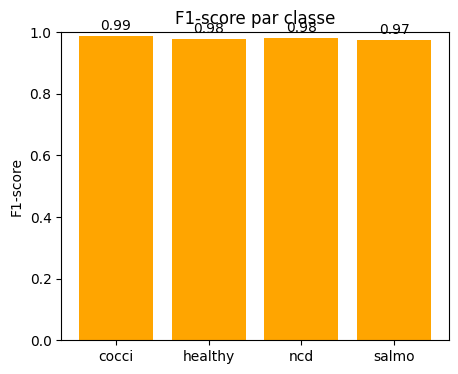

In [15]:
print("Évaluation du modèle final sur le jeu de test...")
test_loss, test_acc = model_mobile.evaluate(test_ds)
print(f"Test Loss = {test_loss:.3f}, Test Accuracy = {test_acc:.3f}")

# Prédictions sur tout le jeu de test
y_pred_probs = model_mobile.predict(test_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_labels_idx  # correspond à test_paths dans le même ordre

# Rapport de classification et matrice de confusion
print("\nClassification Report :")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
cm = confusion_matrix(y_true, y_pred_classes)
print("Matrice de confusion :\n", cm)

# Barplot du score F1 par classe
f1_scores = f1_score(y_true, y_pred_classes, average=None)
plt.figure(figsize=(5,4))
plt.bar(class_names, f1_scores, color='orange')
plt.title("F1-score par classe")
plt.ylim(0,1)
for i, v in enumerate(f1_scores):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.ylabel("F1-score")
plt.show()


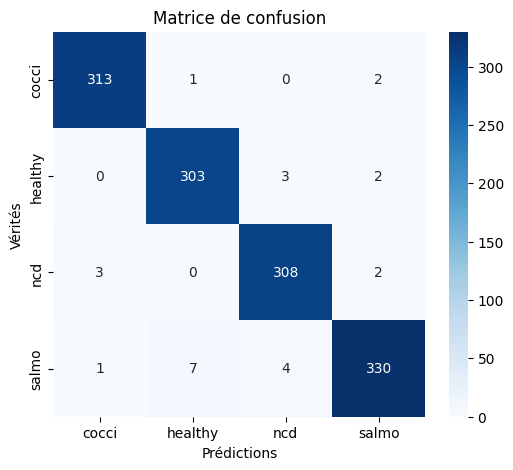

In [16]:
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()

la précision globale est de 98% 

Le rapport de classification montre d'excellents scores F1 (>0.97) pour toutes les classes

La matrice de confusion montre très peu d'erreurs, ce qui est une nette amélioration par rapport à l'analyse précédente. Par exemple, pour la classe ncd, il n'y a que 5 erreurs (3 faux négatifs et 2 faux positifs).

### 9. Analyse d’erreurs sur la classe ncd

Faux négatifs (ncd classées autre) : 5 exemples
Faux positifs (autres classées ncd) : 7 exemples


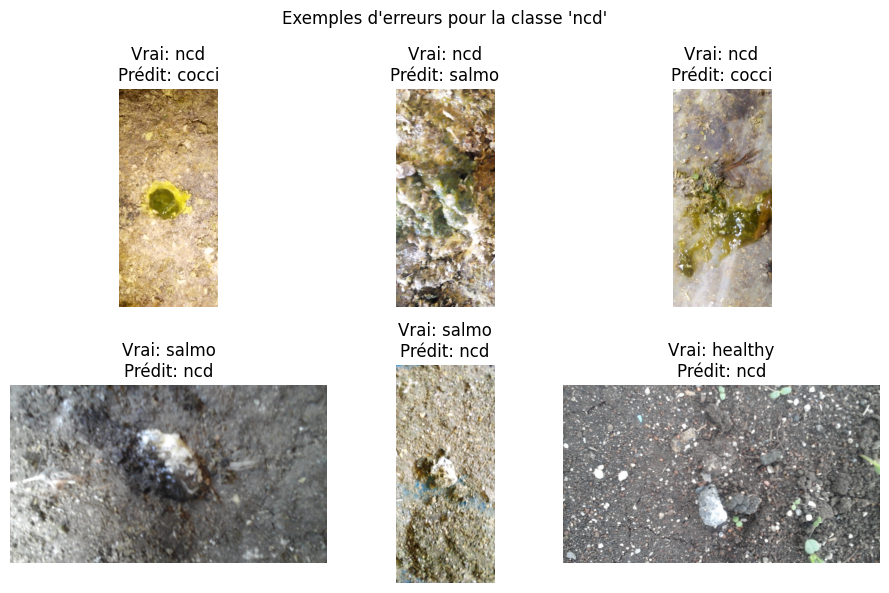

In [17]:
# 9. Analyse des erreurs pour 'ncd'
preds = y_pred_classes
fp_ncd = [i for i,(t,p) in enumerate(zip(y_true, preds)) if t != ncd_idx and p == ncd_idx]
fn_ncd = [i for i,(t,p) in enumerate(zip(y_true, preds)) if t == ncd_idx and p != ncd_idx]

print(f"Faux négatifs (ncd classées autre) : {len(fn_ncd)} exemples")
print(f"Faux positifs (autres classées ncd) : {len(fp_ncd)} exemples")

import matplotlib.image as mpimg

num_show = min(3, len(fn_ncd))
fig, axes = plt.subplots(2, num_show, figsize=(num_show*3,6))
# Afficher quelques faux négatifs en haut, et faux positifs en bas
for j, idx in enumerate(fn_ncd[:num_show]):
    img = mpimg.imread(test_paths[idx])
    axes[0,j].imshow(img)
    axes[0,j].axis('off')
    axes[0,j].set_title(f"Vrai: ncd\nPrédit: {index_to_class[preds[idx]]}")
for j, idx in enumerate(fp_ncd[:num_show]):
    img = mpimg.imread(test_paths[idx])
    axes[1,j].imshow(img)
    axes[1,j].axis('off')
    axes[1,j].set_title(f"Vrai: {index_to_class[y_true[idx]]}\nPrédit: ncd")
plt.suptitle("Exemples d'erreurs pour la classe 'ncd'")
plt.tight_layout()
plt.show()


### 9) Export TFLite + mini inference

In [20]:
# 10. Conversion du modèle Keras vers TFLite
print("Conversion du modèle en TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model_mobile)
tflite_model = converter.convert()
with open("classifier_fientes_v4.tflite", "wb") as f:
    f.write(tflite_model)
print("Modèle TFLite sauvegardé.")

# Inférence TFLite sur des exemples
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_sample_paths = [test_paths[0], test_paths[-1]]
for img_path in test_sample_paths:
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 127.5 - 1
    img = tf.expand_dims(img, axis=0)
    interpreter.set_tensor(input_details[0]['index'], img.numpy())
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred_class = np.argmax(output_data)
    print(f"Image {os.path.basename(img_path)} - Classe prédite (TFLite) : {index_to_class[pred_class]}")
    

Conversion du modèle en TFLite...
INFO:tensorflow:Assets written to: C:\Users\Macky\AppData\Local\Temp\tmplx_a4gw1\assets


INFO:tensorflow:Assets written to: C:\Users\Macky\AppData\Local\Temp\tmplx_a4gw1\assets


Saved artifact at 'C:\Users\Macky\AppData\Local\Temp\tmplx_a4gw1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_165')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2942934918608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942934919184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942934918992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942934917840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942934919376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942932548880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942932540432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942932540048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942932536400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2942932540240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2

c:\Users\Macky\Documents\Projet_St\Classification_d'images\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
